<a href="https://colab.research.google.com/github/idealraushan/Image_Caption_Generator/blob/main/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# the necessary packages are imported

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image


In [2]:
# the pre-trained models and tokenizer are loaded

In [3]:
# model is a pre-trained Vision Encoder-Decoder model based on the GPT-2 architecture, 
# feature_extracter is a pre-trained ViT image processor that extracts features from the images, and 
# tokenizer is a pre-trained tokenizer that is used to tokenize the captions.

In [4]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [5]:
feature_extracter = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [6]:
# max_length sets the maximum number of tokens in the generated captions, and
#  num_beams controls the number of beams to use during generation.

max_length = 16
num_beams = 4

gen_kwargs = {"max_length": max_length,"num_beams": num_beams}


gen_kwargs is a dictionary that contains the arguments to be passed to the generate method of the model when generating captions.

This means that the generate method will be called with two arguments:

1. max_length: an integer that sets the maximum number of tokens in the generated captions.
2. num_beams: an integer that controls the number of beams to use during generation.

By passing gen_kwargs as a keyword argument to the generate method, these arguments are used to control the generation process. For example, the max_length argument ensures that the generated captions do not exceed a certain length, while the num_beams argument controls the diversity of the generated captions by generating multiple captions and choosing the one with the highest probability according to a beam search algorithm.

In [15]:
def predict_step(image_paths):     # predict_step that takes a list of image paths as input
    images = []
    for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode = "RGB")
        images.append(i_image)
        
    pixel_values = feature_extracter(images = images  , return_tensors="pt").pixel_values
    
    output_ids = model.generate(pixel_values,**gen_kwargs)
    
    preds = tokenizer.batch_decode(output_ids , skip_special_tokens =True)
    preds = [pred.strip() for pred in preds]
    return images[0],preds[0]
    

This function takes a list of image paths as input, loads the images using the PIL.Image.open method, converts them to RGB mode if necessary, and appends them to a list called images. Then, the features are extracted from the images using the feature_extracter and converted to PyTorch tensors. The generate method of the model is called with the pixel values and generation arguments, and the resulting token IDs are decoded using the tokenizer.batch_decode method to obtain the generated captions. The generated captions are stripped of whitespace using the strip method and returned as a list

Caption: a collage of photos showing a woman holding a sign


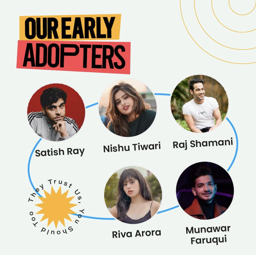

In [16]:
#  call and pass a list containing the path of the image as argument

image , caption = predict_step(["/content/Image3.png"])
print("Caption:",caption)

# Assuming `image` is a PIL Image object
MAX_SIZE = (256, 256)  # Set maximum size for the thumbnail
image.thumbnail(MAX_SIZE)

# Show the thumbnail
image.show()

In [9]:
import gradio as gr

def predict_caption(img):
    image_bytes = img.read()
    image = Image.open(io.BytesIO(image_bytes))
    if image.mode != "RGB":
        image = image.convert(mode="RGB")
    image_path = "image.jpg"
    image.save(image_path)

    captions = predict_step([image_path])[0]
    return captions

iface = gr.Interface(
    fn=predict_caption, 
    inputs=gr.inputs.Image(), 
    outputs=gr.outputs.Textbox(label="Caption")
)

iface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [10]:
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image

app = Flask(__name__)

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extracter = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

max_length = 16
num_beams = 4

gen_kwargs = {"max_length": max_length, "num_beams": num_beams}


@app.route("/")
def home():
    return render_template("index.html")


@app.route("/predict", methods=["POST"])
def predict():
    # Get image from user input
    image = request.files["file"]
    # Open and process image
    image = Image.open(image)
    if image.mode != "RGB":
        image = image.convert(mode="RGB")
    images = [image]

    # Extract features
    pixel_values = feature_extracter(images=images, return_tensors="pt").pixel_values

    # Generate caption
    output_ids = model.generate(pixel_values, **gen_kwargs)
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    caption = preds[0].strip()

    return render_template("result.html", caption=caption)


if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
